In [1]:
# !pip install pytorchts --use-feature=2020-resolver

## Read -> *our* <- data

In [50]:
from pts.model.deepar import DeepAREstimator
from pts.model.simple_feedforward import SimpleFeedForwardEstimator
from pts.model.deepvar.deepvar_estimator import DeepVAREstimator
%load_ext autoreload
%autoreload 2

import torchUtils

from pts.dataset import to_pandas, MultivariateGrouper, TrainDatasets
from pts.dataset.repository import get_dataset, dataset_recipes
from pts.model.tempflow import TempFlowEstimator
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer
from pts.evaluation import make_evaluation_predictions
from pts.evaluation import MultivariateEvaluator

import numpy as np
import pandas as pd

from datetime import datetime

import matplotlib. pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
NEW_DATETIME_COL = 'DateTime'
DATETIME_COL = NEW_DATETIME_COL # for compat with old prepDataNYC NBook
AMBIENT_TEMP_COL = 'Ambient Outdoor Temperature'
ROOM_TEMP_COL = 'Room Air Temperature'
POWER_COL = "Total Unit Power"
SITE_ID_COL = "Site Identification"
DATE_COL = 'Date'
TIME_COL = 'Time'

p = {}
p['power_threshold'] = 100
p['horizon_length'] = 4
p['memory_length'] = 96
p['data_dir'] = "/Users/jonasb/repos/heat-pump-first-paper/output/NYC_data_15min.csv"
p['site_ids'] = ['S43']
p['add_time_features'] = True
p['input_type'] = 'normal'
p['dataloader_type'] = 'full'
p['batch_size'] = 1
p['seq_len'] = 1

def get_data_module(type,
                    override_batch_size : int = p['batch_size'],
                    input_type: str = "normal"):

    # input_type == normal -> regular structure
    #            == flat -> flat structure

    flatten_xs = True if p['input_type'] == 'flat' else False
    if (type == "full"):
        return torchUtils.FullDataModule(
            dataset_path=p["data_dir"],
            seq_len=p['seq_len'],
            batch_size=override_batch_size,  # By default takes from 'p'
            site_ids=p['site_ids'],
            datetime_col=DATETIME_COL,
            power_col=POWER_COL,
            indoor_temp_col=ROOM_TEMP_COL,
            outdoor_temp_col=AMBIENT_TEMP_COL,
            idle_power_threshold=p['power_threshold'],
            horizon_length=p['horizon_length'],
            memory_length=p['memory_length'],
            add_time_features=True,
            flatten_xs=flatten_xs,
        )
    elif (type == "interval"):
        return torchUtils.TemperaturePowerIntervalDataModule(
            dataset_path = p["data_dir"],
            seq_len = p['seq_len'],
            batch_size = override_batch_size, # By default takes from 'p'
            site_ids = p['site_ids'],
            datetime_col = DATETIME_COL,
            power_col = POWER_COL,
            indoor_temp_col = ROOM_TEMP_COL,
            outdoor_temp_col = AMBIENT_TEMP_COL,
            idle_power_threshold = p['power_threshold'],
            horizon_length = p['horizon_length'],
            memory_length = p['memory_length'],
            add_time_features = p['add_time_features'],
            flatten_xs = flatten_xs,
        )
    else:
        raise ValueError(f"Type '{type}' dataloader is unsupported!")

dm = get_data_module(p['dataloader_type'])
dm.setup('fit')

train_dl = dm.train_dataloader()
test_dl = dm.test_dataloader()

Generating full data took: 0:00:09.861296
Flattening took: 0:01:14.301883
Filtering took: 0:00:17.075741
Started caching generated intervals!
NYC_full_train saved generated intervals successfully!
Started caching generated intervals!
NYC_full_val saved generated intervals successfully!
Started caching generated intervals!
NYC_full_test saved generated intervals successfully!
Stacking took: 0:00:13.873229
Setup() done


/Users/jonasb/repos/heat-pump-first-paper/torchUtils.py:578: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xy_df[power_col+f"{horizon_i+1}"] = xy_df[power_col].iloc[memory_length+horizon_i]


In [4]:
# Train dl length (with batch 1)
print(f"dl length: {train_dl.__len__()}")

first_X_batch, first_y_batch = None, None
for X_batch, y_batch in train_dl:
    print(f"X shape: {X_batch.shape}")
    print(f"y shape: {y_batch.shape}")
    first_X_batch = X_batch
    first_y_batch = y_batch
    break

first_X_batch = dm.scaler.inverse_transform(first_X_batch)
first_X_batch

dl length: 22492
X shape: torch.Size([1, 96, 13])
y shape: torch.Size([1, 4])


array([[[ 1.8627222e+01,  6.7222219e+00,  7.6085297e+02, ...,
          2.0012199e+02,  4.3605600e+02, -1.5638247e-05],
        [ 1.8808889e+01,  6.7222219e+00,  2.1612199e+02, ...,
          2.0012199e+02,  4.3605600e+02, -1.5638247e-05],
        [ 1.8524445e+01,  7.2222223e+00, -3.2035534e-06, ...,
          2.0012199e+02,  4.3605600e+02, -1.5638247e-05],
        ...,
        [ 1.9024445e+01,  6.7222219e+00,  9.5589005e+01, ...,
          2.0012199e+02,  4.3605600e+02, -1.5638247e-05],
        [ 1.8888889e+01,  6.7222219e+00,  1.5376700e+02, ...,
          2.0012199e+02,  4.3605600e+02, -1.5638247e-05],
        [ 1.8888889e+01,  6.7222219e+00,  5.8084399e+02, ...,
          2.0012199e+02,  4.3605600e+02, -1.5638247e-05]]], dtype=float32)

In [5]:
# Original dataframe (before split into X and y)

first_item = None

for item in dm.train_xys_filtered:
    print(item)
    first_item = item
    break

                     Room Air Temperature  Ambient Outdoor Temperature  \
DateTime                                                                 
2015-12-04 12:00:00              18.62722                      6.72222   
2015-12-04 12:15:00              18.80889                      6.72222   
2015-12-04 12:30:00              18.52444                      7.22222   
2015-12-04 12:45:00              18.73444                      7.22222   
2015-12-04 13:00:00              18.87667                      7.22222   
...                                   ...                          ...   
2015-12-05 11:45:00              18.88889                      6.72222   
2015-12-05 12:00:00              18.88889                      6.72222   
2015-12-05 12:15:00              18.42611                      6.72222   
2015-12-05 12:30:00              18.83333                      7.77778   
2015-12-05 12:45:00              18.88889                      7.77778   

                     Total Unit Power

In [6]:
#######################################

In [7]:
first_X_batch.shape

(1, 96, 13)

In [8]:
first_item.columns

Index(['Room Air Temperature', 'Ambient Outdoor Temperature',
       'Total Unit Power', 'Day', 'Month', 'Year', 'Hour', 'Minute', 'Weekday',
       'Total Unit Power1', 'Total Unit Power2', 'Total Unit Power3',
       'Total Unit Power4'],
      dtype='object')

In [9]:
dynamic_features = first_X_batch[0, :, 0:3]
dynamic_features

array([[ 1.8627222e+01,  6.7222219e+00,  7.6085297e+02],
       [ 1.8808889e+01,  6.7222219e+00,  2.1612199e+02],
       [ 1.8524445e+01,  7.2222223e+00, -3.2035534e-06],
       [ 1.8734444e+01,  7.2222223e+00,  5.3854401e+02],
       [ 1.8876667e+01,  7.2222223e+00,  3.7598901e+02],
       [ 1.8888889e+01,  7.2222223e+00, -3.2035534e-06],
       [ 1.8851667e+01,  7.2222223e+00,  5.0256699e+02],
       [ 1.9073889e+01,  7.2222223e+00,  7.0089005e+01],
       [ 1.8740555e+01,  7.2222223e+00, -3.2035534e-06],
       [ 1.8512222e+01,  7.2222223e+00,  8.3461102e+02],
       [ 1.8518333e+01,  7.2222223e+00,  1.0530000e+03],
       [ 1.8339445e+01,  7.2222223e+00,  7.9818903e+02],
       [ 1.8888889e+01,  7.2222223e+00,  2.9056011e+01],
       [ 1.8888889e+01,  7.2222223e+00,  2.4103300e+02],
       [ 1.9382223e+01,  6.7222219e+00,  3.5457300e+02],
       [ 1.8987778e+01,  6.7222219e+00, -3.2035534e-06],
       [ 1.8888889e+01,  6.7222219e+00, -3.2035534e-06],
       [ 1.9129444e+01,  6.7222

In [10]:
feature1 = first_X_batch[0, :, 0]
feature2 = first_X_batch[0, :, 1]
feature3 = first_X_batch[0, :, 2]

feature3

array([ 7.6085297e+02,  2.1612199e+02, -3.2035534e-06,  5.3854401e+02,
        3.7598901e+02, -3.2035534e-06,  5.0256699e+02,  7.0089005e+01,
       -3.2035534e-06,  8.3461102e+02,  1.0530000e+03,  7.9818903e+02,
        2.9056011e+01,  2.4103300e+02,  3.5457300e+02, -3.2035534e-06,
       -3.2035534e-06,  4.7646701e+02,  8.9833008e+01, -3.2035534e-06,
       -3.2035534e-06,  5.5348297e+02,  2.3942700e+02,  7.6752203e+02,
        2.0794400e+02,  2.8772198e+02, -3.2035534e-06, -3.2035534e-06,
        5.6572198e+02, -3.2035534e-06, -3.2035534e-06,  1.9582401e+02,
        4.0671100e+02, -3.2035534e-06, -3.2035534e-06,  4.2815598e+02,
        1.3211200e+02, -3.2035534e-06,  3.5751102e+02,  1.2613639e+03,
        4.9717801e+02, -3.2035534e-06, -3.2035534e-06,  2.1476700e+02,
        8.4371906e+02,  8.1752203e+02,  6.2378002e+01, -3.2035534e-06,
       -3.2035534e-06,  6.3329999e+02,  8.8113300e+02,  5.2556702e+02,
        4.9208899e+02,  3.4219940e+00, -3.2035534e-06, -3.2035534e-06,
      

In [11]:
y = first_y_batch.reshape(4).numpy()
feature1y = np.concatenate([feature1, y])[4:]
feature1y.shape

(96,)

In [12]:
static_date_features = first_X_batch[0, 0, 3:3+6]
static_date_features

array([   3.9999995,   12.       , 2015.       ,   12.       ,
          0.       ,    4.       ], dtype=float32)

In [13]:
start = datetime(int(static_date_features[2]),
         int(static_date_features[1]),
         int(static_date_features[0]),
         hour=int(static_date_features[3]),
         minute=int(static_date_features[4]))
start

datetime.datetime(2015, 12, 3, 12, 0)

In [14]:
static_power_interval = first_X_batch[0, 0, 9:]
static_power_interval

array([ 1.6562077e-05,  2.0012199e+02,  4.3605600e+02, -1.5638247e-05],
      dtype=float32)

In [15]:
import numpy as np
import pandas as pd

def create_dataset(num_series, num_steps, period=24, mu=1, sigma=0.3):
    # create target: noise + pattern
    # noise
    noise = np.random.normal(mu, sigma, size=(num_series, num_steps))

    # pattern - sinusoid with different phase
    sin_minumPi_Pi = np.sin(np.tile(np.linspace(-np.pi, np.pi, period), int(num_steps / period)))
    sin_Zero_2Pi = np.sin(np.tile(np.linspace(0, 2 * np.pi, 24), int(num_steps / period)))

    pattern = np.concatenate((np.tile(sin_minumPi_Pi.reshape(1, -1),
                                      (int(np.ceil(num_series / 2)),1)),
                              np.tile(sin_Zero_2Pi.reshape(1, -1),
                                      (int(np.floor(num_series / 2)), 1))
                             ),
                             axis=0
                            )

    target = noise + pattern

    # create time features: use target one period earlier, append with zeros
    feat_dynamic_real = np.concatenate((np.zeros((num_series, period)),
                                        target[:, :-period]
                                       ),
                                       axis=1
                                      )

    # create categorical static feats: use the sinusoid type as a categorical feature
    feat_static_cat = np.concatenate((np.zeros(int(np.ceil(num_series / 2))),
                                      np.ones(int(np.floor(num_series / 2)))
                                     ),
                                     axis=0
                                    )

    return target, feat_dynamic_real, feat_static_cat


# define the parameters of the dataset
custom_ds_metadata = {'num_series': 100,
                      'num_steps': 24 * 7,
                      'prediction_length': 24,
                      'freq': '1H',
                      'start': [pd.Timestamp("01-01-2019", freq='1H')
                                for _ in range(100)]
                     }

data_out = create_dataset(custom_ds_metadata['num_series'],
                          custom_ds_metadata['num_steps'],
                          custom_ds_metadata['prediction_length']
                         )

target, feat_dynamic_real, feat_static_cat = data_out

print(f"Target shape: {target.shape}")
print(f"Feat dynamic real shape: {feat_dynamic_real.shape}")
print(f"Feat static cat shape: {feat_static_cat.shape}")

Target shape: (100, 168)
Feat dynamic real shape: (100, 168)
Feat static cat shape: (100,)


In [16]:
# One example 'object'
lst = [{'target': target,
       'start': start,
       'feat_dynamic_real': [fdr],
       'feat_static_cat': [fsc]}
       for (target, start, fdr, fsc) in zip(target[:, :-custom_ds_metadata['prediction_length']],
                                         custom_ds_metadata['start'],
                                         feat_dynamic_real[:, :-custom_ds_metadata['prediction_length']],
                                         feat_static_cat)]
example_object = lst[0]

# https://github.com/awslabs/gluon-ts/blob/master/docs/examples/extended_forecasting_tutorial/extended_tutorial.md


print(f"Target shape: {example_object['target'].shape}")
print(f"Start: {example_object['start']}")
print(f"Feat dynamic real: {example_object['feat_dynamic_real'][0].shape}")
print(f"Feat static cat: {example_object['feat_static_cat'][0]}")

Target shape: (144,)
Start: 2019-01-01 00:00:00
Feat dynamic real: (144,)
Feat static cat: 0.0


In [73]:
import pts.dataset as ptsd

# TODO: turn the train_xys_filtered to the required format

def transformForXysData(X_batch, y_batch):
    X_batch = dm.scaler.inverse_transform(X_batch)
    static_date_features = X_batch[0, 0, 3:3+6]
    # start = datetime(
    #      year=int(static_date_features[2]),
    #      month=int(3),
    #      day=int(static_date_features[0]),
    #      hour=int(static_date_features[3]),
    #      minute=int(static_date_features[4]))

    start = datetime(
        year=2020,
        month=11,
        day=22,
        hour=0,
        minute=0
    )
    feature1 = X_batch[0, :, 0]
    feature2 = X_batch[0, :, 1]
    feature3 = X_batch[0, :, 2]
    freq="15min"

    y = y_batch.reshape(4).numpy()
    feature1y = np.concatenate([feature1, y])[4:]

    return {
        "start": pd.Timestamp(start, freq=freq),
        "feat_dynamic_real": [feature1, feature2, feature3],
        "feat_static_real": list(X_batch[0, 0, 9:].reshape(4)), # Trying to listify
        "target": feature1y
    }

In [74]:
print("Making train objects")
train_ts_objects = []
i = 1
for X_batch, y_batch in train_dl:
    if (i % 1000):
        print(".", end='')
    train_ts_objects.append(transformForXysData(X_batch, y_batch))
    i+=1

Making train objects
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [75]:
example_object = train_ts_objects[0]
print(f"Target shape: {example_object['target'].shape}")
print(f"Start: {example_object['start']}")
print(f"Feat dynamic real 1: {example_object['feat_dynamic_real'][0].shape}")
print(f"Feat dynamic real 2: {example_object['feat_dynamic_real'][1].shape}")
print(f"Feat dynamic real 3: {example_object['feat_dynamic_real'][2].shape}")
# print(f"Feat static real: {example_object['feat_static_real'][0].shape}")

Target shape: (96,)
Start: 2020-11-22 00:00:00
Feat dynamic real 1: (96,)
Feat dynamic real 2: (96,)
Feat dynamic real 3: (96,)


In [76]:
print("Making test objects")
test_ts_objects = []
i = 0
for X_batch, y_batch in test_dl:
    if (i % 1000):
        print(".", end='')
    test_ts_objects.append(transformForXysData(X_batch, y_batch))
    i+=1

test_ts_objects[0]

Making test objects
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

{'start': Timestamp('2020-11-22 00:00:00', freq='15T'),
 'feat_dynamic_real': [array([18.357779, 18.864445, 18.876667, 18.642221, 18.333334, 18.555555,
         18.586666, 18.88889 , 18.592777, 18.962778, 18.777779, 18.333334,
         18.821112, 19.037222, 18.512222, 18.339445, 18.549444, 18.870556,
         19.444445, 18.913334, 18.506111, 18.506111, 19.444445, 18.944445,
         18.648333, 18.333334, 19.302221, 18.938334, 18.53111 , 18.333334,
         19.012222, 18.938334, 18.524445, 19.024445, 19.12    , 18.407223,
         18.481667, 19.073889, 18.851667, 18.555555, 18.88889 , 18.475555,
         18.555555, 18.376667, 18.88889 , 18.58    , 18.345556, 18.88889 ,
         18.58    , 18.555555, 18.5     , 18.88889 , 18.5     , 18.759445,
         18.88889 , 18.42    , 18.592777, 18.69111 , 18.88889 , 18.370556,
         18.88889 , 18.88889 , 18.339445, 18.592777, 18.740555, 18.70389 ,
         18.777779, 18.962778, 18.707777, 18.88889 , 18.882778, 18.333334,
         18.518333, 18.

In [77]:
from pts.dataset import ListDataset
train_ds = ListDataset(train_ts_objects, freq="15min")
test_ds = ListDataset(test_ts_objects, freq="15min")
train_ds

In [ ]:
type(train_ds)

In [78]:
from pts.dataset import to_pandas, MultivariateGrouper, TrainDatasets

train_grouper = MultivariateGrouper(max_target_dim=int(len(train_ds)))

test_grouper = MultivariateGrouper(max_target_dim=int(len(test_ds)))

dataset_train = train_grouper(train_ds)
dataset_test = test_grouper(test_ds)

type(dataset_train)

pts.dataset.list_dataset.ListDataset

In [23]:
i = 0
for item in dataset_train:
    print(item)
    print(len(item['target']))
    i += 1
    if (i > 2):
        break

len(train_ds) #target dim

{'target': array([[18.876667, 18.88889 , 18.851667, ..., 18.426111, 18.833334,
        18.88889 ],
       [18.88889 , 18.851667, 19.073889, ..., 18.833334, 18.88889 ,
        18.88889 ],
       [18.851667, 19.073889, 18.740555, ..., 18.88889 , 18.88889 ,
        18.88889 ],
       ...,
       [19.444445, 19.444445, 19.950556, ..., 20.      , 20.29    ,
        20.      ],
       [19.444445, 19.950556, 20.302221, ..., 20.29    , 20.      ,
        20.      ],
       [19.950556, 20.302221, 20.      , ..., 20.      , 20.      ,
        20.      ]], dtype=float32), 'start': Timestamp('2020-11-22 00:00:00', freq='15T'), 'feat_static_cat': array([0]), 'source': SourceContext(source='list_data', row=1)}
22492


22492

## Train the model (TransformerTempFlow)

We can now train the TransformerTempFlow model on the grouped dataset.

In [80]:
import torch
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
prediction_length = 4

# https://ts.gluon.ai/api/gluonts/gluonts.model.deepvar.html

# Using AR because - https://github.com/awslabs/gluon-ts/issues/652
# Probably shouldn't use the grouper thingy and use the dataset directly
estimator = DeepAREstimator(
    prediction_length=4,
    # target_dim=len(train_ds),
    freq="15min",
    trainer=Trainer(
        epochs=6,
        learning_rate=1e-3,
        num_batches_per_epoch=len(train_ds)//16,
        batch_size=16,
        
    ),
    # input_size=1,
    # context_length=4, # default = prediction_length
    cell_type="GRU", # default LSTM
    use_feat_dynamic_real=True,
    use_feat_static_real=True,
    # use_feat_static_cat=True,
    input_size=50,

)


# target_dim --- number of series in dataset
# prediction_length --- prediction length (4?)
# freq ---


predictor = estimator.train(training_data=train_ds)

1404it [00:46, 30.42it/s, avg_epoch_loss=0.487, epoch=0]
1404it [00:45, 30.73it/s, avg_epoch_loss=0.184, epoch=1]
1404it [00:47, 29.63it/s, avg_epoch_loss=0.183, epoch=2]
1404it [00:46, 30.30it/s, avg_epoch_loss=0.169, epoch=3]
1404it [00:47, 29.26it/s, avg_epoch_loss=0.165, epoch=4]
1404it [00:47, 29.64it/s, avg_epoch_loss=0.154, epoch=5]


In [81]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
ts = list(ts_it)

forecast_entry = forecasts[0]
ts_entry = ts[0]

In [52]:
forecast_entry

SampleForecast(array([[18.345663, 18.54006 , 18.408606, 18.658838],
       [18.56158 , 18.636518, 18.546148, 18.512438],
       [18.96926 , 18.726458, 18.15457 , 18.488674],
       [18.407679, 18.86808 , 19.03822 , 19.159622],
       [17.4976  , 18.714594, 18.722492, 18.760298],
       [18.932873, 18.407995, 18.317427, 18.999414],
       [18.627575, 18.4768  , 18.604565, 18.625526],
       [18.544683, 18.56225 , 18.106401, 18.328432],
       [19.030973, 19.468641, 18.429304, 18.072033],
       [18.351656, 18.65892 , 18.6787  , 18.496939],
       [18.862823, 18.354467, 18.60111 , 18.71798 ],
       [18.418005, 18.021235, 18.41184 , 18.435389],
       [18.965818, 19.020676, 18.36867 , 18.439533],
       [18.70313 , 18.441189, 18.481514, 18.351816],
       [18.477665, 18.434752, 18.551659, 18.519451],
       [18.55432 , 18.521036, 19.225374, 18.565807],
       [18.595861, 18.611782, 18.108072, 18.368689],
       [18.790766, 18.805082, 18.776787, 18.746063],
       [18.406324, 18.379776, 1

In [53]:
ts_entry

0
2020-11-22 00:00:00 18.33333
2020-11-22 00:15:00 18.55556
2020-11-22 00:30:00 18.58667
2020-11-22 00:45:00 18.88889
2020-11-22 01:00:00 18.59278
...                      ...
2020-11-22 22:45:00 18.41333
2020-11-22 23:00:00 18.59278
2020-11-22 23:15:00 18.88889
2020-11-22 23:30:00 18.80889
2020-11-22 23:45:00 18.33333

[96 rows x 1 columns]

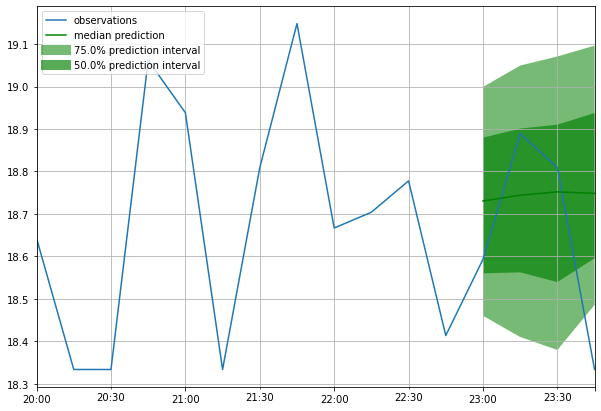

In [83]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 16
    prediction_intervals = (50.0, 75.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

plot_prob_forecasts(ts_entry, forecast_entry)

# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

In [ ]:
from pts.dataset import ListDataset

# train_ds = ListDataset([{FieldName.TARGET: target,
#                          FieldName.START: start,
#                          FieldName.FEAT_DYNAMIC_REAL: [fdr],
#                          FieldName.FEAT_STATIC_CAT: [fsc]}
#                         for (target, start, fdr, fsc) in zip(target[:, :-custom_ds_metadata['prediction_length']],
#                                                              custom_ds_metadata['start'],
#                                                              feat_dynamic_real[:, :-custom_ds_metadata['prediction_length']],
#                                                              feat_static_cat)],
#                       freq=custom_ds_metadata['freq'])

In [86]:
from pts.evaluation import make_evaluation_predictions, Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9], num_workers=0)
agg_metrics, item_metrics = evaluator(iter(ts), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 1280/1280 [00:08<00:00, 154.67it/s]


In [88]:
import json
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.26577067169855584,
    "abs_error": 2093.815324783325,
    "abs_target_sum": 106282.56651306152,
    "abs_target_mean": 20.758313772082328,
    "seasonal_error": 0.2333714282119667,
    "MASE": 3.9978148390581962,
    "MAPE": 0.019472422776309638,
    "sMAPE": 0.019485945960074188,
    "OWA": NaN,
    "MSIS": 32.708065417621874,
    "QuantileLoss[0.1]": 930.8118949890137,
    "Coverage[0.1]": 0.201171875,
    "QuantileLoss[0.5]": 2093.815324783325,
    "Coverage[0.5]": 0.5349609375,
    "QuantileLoss[0.9]": 1087.539292526245,
    "Coverage[0.9]": 0.8029296875,
    "RMSE": 0.5155295061376757,
    "NRMSE": 0.024834845055237902,
    "ND": 0.01970045881914234,
    "wQuantileLoss[0.1]": 0.008757898172082834,
    "wQuantileLoss[0.5]": 0.01970045881914234,
    "wQuantileLoss[0.9]": 0.010232527574431433,
    "mean_wQuantileLoss": 0.012896961521885535,
    "MAE_Coverage": 0.07773437499999998
}


## Read in data

First we read in the training data, which contains sales of shop + item combinations (lowest level of the hierarchy).

In [ ]:
import pandas as pd

sales_train = pd.read_csv("/Users/jonasb/Downloads/competitive-data-science-predict-future-sales/sales_train.csv")
sales_train.date = pd.to_datetime(sales_train.date)
sales_train.head()

In [ ]:
sales_train.describe()

As we can see, there are 60 unique shops in the training data.

In [ ]:
sales_train.shop_id.nunique()

We remove records having a negative item price.

In [ ]:
sales_train = sales_train[sales_train['item_price'] > 0]

Next, we set the records having a negative count (sales) to zero.

In [ ]:
sales_train.loc[sales_train['item_cnt_day'] < 0,'item_cnt_day'] = 0

Let's plot the prices and counts:

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
#
# f, (ax1, ax2) = plt.subplots(figsize=(14,4), nrows=1, ncols=2)
# sns.boxplot(sales_train['item_price'].dropna(), ax=ax1)
# sns.boxplot(sales_train['item_cnt_day'].dropna(), ax=ax2)
# f.suptitle('Distribution of item price and item sales per day')

We remove outliers:

In [ ]:
sales_train = sales_train[sales_train.item_price < 100000]
sales_train = sales_train[sales_train.item_cnt_day < 1001]

## Middle-out approach: shop level

In order to perform a middle-out approach, we are going to aggregate the sales at the shop level.

In [ ]:
per_shop = sales_train.groupby(['shop_id','date'], as_index=False)['item_cnt_day'].sum()
per_shop

Here we create the targets as required by PyTorch-ts. 

In [ ]:
data = {}
date_indices = pd.date_range(
        start=per_shop.date.min(),
        end=per_shop.date.max(),
        freq='D'
    )
target = pd.DataFrame(data, index=date_indices)

for shop_id in range(per_shop.shop_id.nunique()):
    daily_sales = per_shop.loc[per_shop['shop_id'] == shop_id]
    daily_sales = daily_sales.drop(["shop_id"], axis=1).set_index('date')
    daily_sales = daily_sales.rename(columns={"item_cnt_day": shop_id})
    # append to dataframe
    target[shop_id] = daily_sales

target.head()

In [ ]:
target.tail()

## Plotting the sales of shops

In [ ]:
# let's plot the first 20 shops
# for c in range(0,20):
#     fig = plt.figure(figsize=(12,3))
#     plt.plot(target[c])
#     plt.title('shop_id: %d' %(c))

## Reading in the test set

As we read in the test set, we see that there are actually only 42 of the 60 shops from the training set present.

In [ ]:
test_set = pd.read_csv("/Users/jonasb/Downloads/competitive-data-science-predict-future-sales/test.csv")
test_set.head()

In [ ]:
test_set.tail()

In [ ]:
test_set.shop_id.nunique()

Let's filter the targets of the training set, to only contain those of the shops that are present in the test set:

In [ ]:
test_set.shop_id.value_counts().index.sort_values()

In [ ]:
targets_shops_test_set = target.iloc[:, test_set.shop_id.value_counts().index.sort_values()]
targets_shops_test_set

Let's check how many missing values there are for each of the shops:

In [ ]:
targets_shops_test_set.isnull().sum()

Let's fill in missing values by zeros:

In [ ]:
targets_shops_test_set = targets_shops_test_set.fillna(0)
targets_shops_test_set

We can now plot the sales for each shop of the test set, with the missing values filled in:

In [ ]:
# let's plot the first 20
# for c in test_set.shop_id.value_counts().index.sort_values()[:20]:
#     fig = plt.figure(figsize=(12,3))
#     plt.plot(targets_shops_test_set[c])
#     plt.title('shop_id: %d' %(c))

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

## Creating the PyTorch TS datasets

Here we create the train_ds and test_ds ListDataset objects, which contain the 42 time series.

In [ ]:
from pts.dataset import ListDataset, FieldName

start = targets_shops_test_set.index[0]
num_series = targets_shops_test_set.shape[1]
prediction_length = 31
freq = "D"

data = targets_shops_test_set.T # shape (10, 1913)

print(f"start: {start}")
print(f"num_series: {num_series}")

In [ ]:
data

In [ ]:
train_ds = ListDataset([{FieldName.TARGET: target,
                         FieldName.START: start}
                        for (target, start) in zip(data.values[:, :-prediction_length], # shape (42, 1003) 
                                                   [pd.Timestamp(start, freq=freq) for _ in range(num_series)])
                        ],
                        freq=freq)

test_ds = ListDataset([{FieldName.TARGET: target,
                        FieldName.START: start}
                       for (target, start) in zip(data.values, # shape (42, 1034)
                                                  [pd.Timestamp(start, freq=freq) for _ in range(num_series)])
                      ],
                        freq=freq)

In [ ]:
# WTF is this
# <<< Train
[{FieldName.TARGET: target,
  FieldName.START: start}
for (target, start) in zip(data.values[:, :-prediction_length], # shape (42, 1003)
                           [pd.Timestamp(start, freq=freq) for _ in range(num_series)])
]

In [ ]:
[{FieldName.TARGET: target,
              FieldName.START: start}
for (target, start) in zip(data.values, # shape (42, 1034)
                           [pd.Timestamp(start, freq=freq) for _ in range(num_series)])
]

In [ ]:
from pts.dataset import to_pandas

# print out the first time series of the training set
train_entry = next(iter(train_ds))
train_series = to_pandas(train_entry)
train_series

In [ ]:
# print out the first time series of the test set (which is the same as the one above, but a bit longer)
test_entry = next(iter(test_ds))
test_series = to_pandas(test_entry)
test_series

Let's visualize the first time series (both train + test):

In [ ]:
# import matplotlib.pyplot as plt
#
# fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
#
# train_series.plot(ax=ax[0])
# ax[0].grid(which="both")
# ax[0].legend(["train series"], loc="upper left")
#
# test_series.plot(ax=ax[1])
# ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
# ax[1].grid(which="both")
# ax[1].legend(["test series", "end of train series"], loc="upper left")
#
# plt.show()

As TransformerTempFlow is a multivariate model, we use the grouper to make the target two-dimensional:

In [ ]:
from pts.dataset import to_pandas, MultivariateGrouper, TrainDatasets

train_grouper = MultivariateGrouper(max_target_dim=int(len(train_ds)))

test_grouper = MultivariateGrouper(num_test_dates=int(len(test_ds)/len(train_ds)), 
                                   max_target_dim=int(len(train_ds)))

dataset_train = train_grouper(train_ds)
dataset_test = test_grouper(test_ds)

In [ ]:
i = 0
for item in dataset_train:
    print(item)
    print(len(item['target']))
    i += 1
    if (i > 2):
        break

len(train_ds) #target dim

## Train the model (TransformerTempFlow)

We can now train the TransformerTempFlow model on the grouped dataset.

In [ ]:
prediction_length

In [ ]:
print("hello")
for item in train_ds:
    print(item)
    target = item['target']
    print(target)
    print(target.shape)
    break



In [ ]:
import torch
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

estimator = TransformerTempFlowEstimator(
    d_model=16,
    num_heads=4,
    input_size=42,
    target_dim=len(train_ds),
    prediction_length=prediction_length,
    flow_type='MAF',
    dequantize=True,
    freq=freq,
    trainer=Trainer(
        device=device,
        epochs=14,
        learning_rate=1e-3,
        num_batches_per_epoch=100,
        batch_size=64,
    )
)

predictor = estimator.train(training_data=dataset_train)

## Legacy

In [ ]:
# add id of test set to training set
result = pd.merge(sales_train, test_set, how='left', on=['shop_id','item_id'])
result.head()

In [ ]:
result.loc[result.ID == 0].shape[0]

In [ ]:
test_set.shop_id.value_counts()

In [ ]:
for shop_id in test_set.shop_id:
    print(shop_id, result.loc[result.shop_id == shop_id].shape[0])

In [ ]:
result.loc[(result['shop_id']==5) & (result['item_id'] == 5037)]

In [ ]:
result.loc[(result['shop_id'] == 25) & (result['item_id'] == 2552)]

In [ ]:
result.ID.isna().sum()

In [ ]:
result.ID.nunique()

In [ ]:
test_set.ID.nunique()